[Dataset link](https://www.kaggle.com/code/lumenalux/balanced-dataset-in-h5-format-3-67gb)

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_dataset(path="balanced_dataset.h5"):
    rf_dataset = pd.DataFrame()

    with h5py.File(path, 'r') as f:
        for cls in f.keys():
            df = pd.DataFrame({
                'snrs': np.array(f[f'{cls}/snrs']),
                'duty_cycle': np.array(f[f'{cls}/duty_cycle']),
                'x_iq': list(f[f'{cls}/x_iq']),
                'x_spec': list(f[f'{cls}/x_spec']),
                'y': np.array(f[f'{cls}/y']),
            })
            rf_dataset = pd.concat([rf_dataset, df], ignore_index=True)

    return rf_dataset


In [17]:
from typing import List
from scipy.stats import skew, kurtosis
from scipy.fft import fft


def extract_spectrogram_features(
        spectrogram:pd.Series
    ) -> List:
    '''
    Function to extract features from spectrogram
    Args:
        spectrogram: Series of spectrogram data

    Returns: [Mean value, Median value, STD, Skewness, Kurtosis]

    '''
    mean_val = np.mean(spectrogram)
    median_val = np.median(spectrogram)
    std_val = np.std(spectrogram)
    skewness = skew(spectrogram.flatten())
    kurt = kurtosis(spectrogram.flatten())
    return [mean_val, median_val, std_val, skewness, kurt]


def extract_iq_features(
        iq_data:pd.Series
    ) -> List:
    '''
    Function to extract features from iq 
    Args:
        iq_data: Series of iq data

    Returns:[Mean value, Median_value, STD, Skewness, Kurtosis, Dominant frequency, Variance of frequency]

    '''

    iq_features = []

    for channel in iq_data:
        mean_val = np.mean(channel)
        median_val = np.median(channel)
        std_val = np.std(channel)
        skewness = skew(channel)
        kurt = kurtosis(channel)

        freq_domain = fft(channel)
        dominant_freq = np.argmax(np.abs(freq_domain))
        freq_variance = np.var(np.abs(freq_domain))

        iq_features.extend([mean_val, median_val, std_val, skewness, kurt, dominant_freq, freq_variance])

    return iq_features


def create_feature_dataframe(x_iq:pd.Series,
                             x_spec:pd.Series,
                             y:pd.Series,
                             snrs:pd.Series,
                             duty_cycle:pd.Series
    ) -> pd.DataFrame:
    '''
    Creates a DataFrame from early extracted features of data
    Args:
        x_iq: 
        x_spec: 
        y: 
        snrs: 
        duty_cycle: 

    Returns:

    '''
    features = []
    for iq, spec, label, snr, duty in zip(x_iq, x_spec, y, snrs, duty_cycle):
        spectrogram_features = extract_spectrogram_features(spec)
        iq_features = extract_iq_features(iq)
        features.append(spectrogram_features + iq_features + [snr, duty, label])

    columns = ['spec_mean', 'spec_median', 'spec_std', 'spec_skew', 'spec_kurt',
               'iq_mean_ch1', 'iq_median_ch1', 'iq_std_ch1', 'iq_skew_ch1', 'iq_kurt_ch1', 'iq_dom_freq_ch1', 'iq_freq_var_ch1',
               'iq_mean_ch2', 'iq_median_ch2', 'iq_std_ch2', 'iq_skew_ch2', 'iq_kurt_ch2', 'iq_dom_freq_ch2', 'iq_freq_var_ch2',
               'snr', 'duty_cycle', 'label']
    df = pd.DataFrame(features, columns=columns)
    return df


In [4]:
from typing import Tuple


def plot_input_data(spectrogram_2d,
                    iq_2d:pd.Series,
                    title:str='',
                    figsize:Tuple[int,int]=(10,9)
    )->None:
    '''
    Plot of the spectrogram and iq data
    Args:
        spectrogram_2d: 
        iq_2d: 
        title: 
        figsize: 

    Returns:

    '''
    fig, axs = plt.subplot_mosaic([['spec_re', 'spec_im'], ['spec_re', 'spec_im'], ['iq_re', 'iq_re'], ['iq_im', 'iq_im']], figsize=figsize)

    # plot spectrogram Re and Im
    spec_re = axs['spec_re'].imshow(spectrogram_2d[0,:,:]) #, aspect='auto', origin='lower')
    axs['spec_re'].set_title('Re', fontsize=10)
    fig.colorbar(spec_re, ax=axs['spec_re'], shrink=0.5)

    spec_im = axs['spec_im'].imshow(spectrogram_2d[1,:,:]) #, aspect='auto', origin='lower')
    axs['spec_im'].set_title('Im', fontsize=10)
    fig.colorbar(spec_im, ax=axs['spec_im'], shrink=0.5)

    # plot iq Re and Im
    axs['iq_re'].plot(iq_2d[0,:])
    axs['iq_re'].set_title('IQ data')
    axs['iq_re'].set_ylabel('Re', rotation=0)

    axs['iq_im'].plot(iq_2d[1,:])
    # axs['iq_im'].set_title('Im')
    axs['iq_im'].set_xlabel('Time (samples)')
    axs['iq_im'].set_ylabel('Im', rotation=0)
    
    plt.show()


## Graph of data sample

In [5]:
df = read_dataset()
df.head()

,snrs,duty_cycle,x_iq,x_spec,y
0,-18,1.000000,"[[-1.7037327, -0.99873316, -0.035902604, 0.219...","[[[0.01630933, -0.016540058, -0.006597518, -0....",0
1,-10,0.060547,"[[-0.2119061, -0.3759562, 1.4548285, -1.276124...","[[[-0.017251128, 0.0016958712, -0.0030887218, ...",0
2,-6,0.975769,"[[-0.25525343, 0.27856958, -0.26633498, 0.1205...","[[[-0.0025569443, 0.0074404734, 0.0022911315, ...",0
3,0,0.869324,"[[-0.3779635, -0.10132809, -0.24967794, 0.6035...","[[[-0.002177195, -0.00064718095, 0.0035892264,...",0
4,0,0.494568,"[[0.61507225, -0.5248958, -0.09456021, 0.37134...","[[[0.00097559235, 0.0018039008, 0.001442022, -...",0


In [12]:

sample_id = 100

y = df['y'][sample_id]
act_snr = df['snrs'][sample_id]
act_duty_cycle = df['duty_cycle'][sample_id]
plt_title = f'Sample# {sample_id}' + ', SNR: '+ str(act_snr) + 'dB, Duty Cycle: 1'
spectrogram_2d = list(df['x_spec'])[sample_id]
iq_2d = list(df['x_iq'])[sample_id]


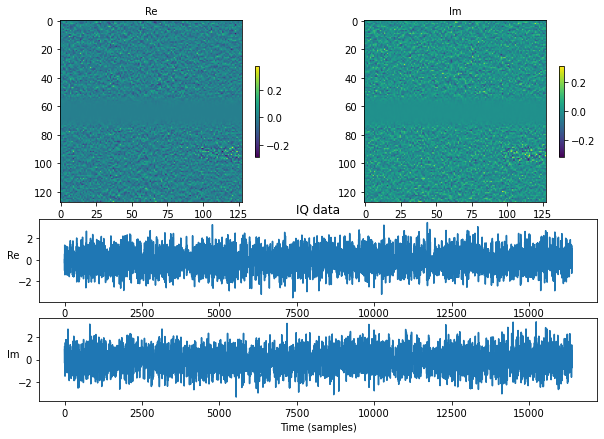

In [13]:
plot_input_data(spectrogram_2d, iq_2d, title=plt_title, figsize=(10,7))

In [30]:
#Creating the dataframe with rf features 
feature_df = create_feature_dataframe(df['x_iq'], df['x_spec'], df['y'], df['snrs'], df['duty_cycle'])


NameError: name 'df' is not defined

In [33]:
feature_df.head()

,spec_mean,spec_median,spec_std,spec_skew,spec_kurt,iq_mean_ch1,iq_median_ch1,iq_std_ch1,iq_skew_ch1,iq_kurt_ch1,...,iq_mean_ch2,iq_median_ch2,iq_std_ch2,iq_skew_ch2,iq_kurt_ch2,iq_dom_freq_ch2,iq_freq_var_ch2,snr,duty_cycle,label
0,6.730261e-11,0.000105,0.065465,0.013334,0.002356,0.007674,0.008341,0.704447,-0.020210,0.016044,...,-0.000129,0.005950,0.711413,0.013001,-0.008870,2148,1789.207764,-18,1.000000,0
1,-5.275069e-11,-0.000063,0.062572,0.001751,0.032107,0.012377,0.009335,0.674582,0.020362,0.023770,...,-0.000205,0.008813,0.677812,0.033838,0.083367,6463,1611.111328,-10,0.060547,0
2,6.093615e-11,-0.000332,0.065096,0.042297,3.726832,0.000697,-0.003533,0.701659,0.013027,0.055632,...,-0.002807,-0.001249,0.707942,-0.013068,0.007531,6902,2316.233154,-6,0.975769,0
3,1.637090e-11,-0.000029,0.063343,0.150549,28.118205,-0.009493,-0.008165,0.679978,0.012712,0.865761,...,-0.007454,-0.013293,0.690453,0.043088,0.839594,6916,3573.863281,0,0.869324,0
4,-3.456080e-11,0.000145,0.056499,-0.020056,6.912236,-0.006364,-0.007516,0.611992,-0.005669,0.333767,...,-0.002259,-0.007291,0.610395,0.026689,0.338416,3460,1732.987549,0,0.494568,0


In [20]:
#Optional
del(df) # to free up space

NameError: name 'df' is not defined

array([[<AxesSubplot:title={'center':'spec_mean'}>,
        <AxesSubplot:title={'center':'spec_median'}>,
        <AxesSubplot:title={'center':'spec_std'}>,
        <AxesSubplot:title={'center':'spec_skew'}>,
        <AxesSubplot:title={'center':'spec_kurt'}>],
       [<AxesSubplot:title={'center':'iq_mean_ch1'}>,
        <AxesSubplot:title={'center':'iq_median_ch1'}>,
        <AxesSubplot:title={'center':'iq_std_ch1'}>,
        <AxesSubplot:title={'center':'iq_skew_ch1'}>,
        <AxesSubplot:title={'center':'iq_kurt_ch1'}>],
       [<AxesSubplot:title={'center':'iq_dom_freq_ch1'}>,
        <AxesSubplot:title={'center':'iq_freq_var_ch1'}>,
        <AxesSubplot:title={'center':'iq_mean_ch2'}>,
        <AxesSubplot:title={'center':'iq_median_ch2'}>,
        <AxesSubplot:title={'center':'iq_std_ch2'}>],
       [<AxesSubplot:title={'center':'iq_skew_ch2'}>,
        <AxesSubplot:title={'center':'iq_kurt_ch2'}>,
        <AxesSubplot:title={'center':'iq_dom_freq_ch2'}>,
        <AxesSubplot

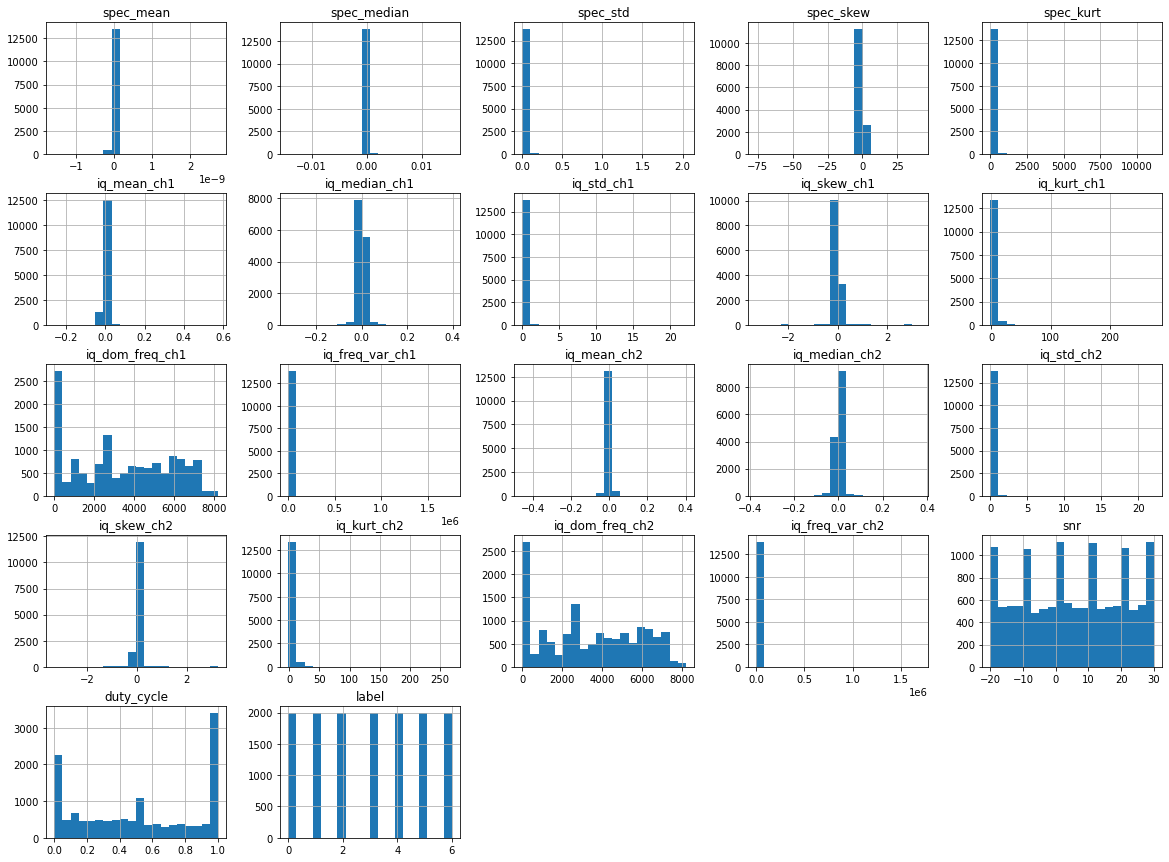

In [21]:
feature_df.hist(figsize=(20,15), bins=20)

In [235]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    feature_df.drop("label", axis=1), feature_df['label'], test_size=0.2, random_state=42)

In [236]:
print(X_train.shape, y_train.shape)

(11200, 21) (11200,)


In [237]:
# Optional
# Normalizing data for numerical stability
from sklearn.preprocessing import StandardScaler

ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)


In [55]:
models = {}
history = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(max_iter=3000)

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


accuracy, precision, recall = {}, {}, {}

for key in models.keys():

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predictions = models[key].predict(X_test)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test,average='micro')
    recall[key] = recall_score(predictions, y_test,average='micro')


C:\Users\user\anaconda3\envs\keras-main\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [57]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.424286,0.424286,0.424286
Support Vector Machines,0.410000,0.410000,0.410000
Decision Trees,0.307500,0.307500,0.307500
Random Forest,0.480000,0.480000,0.480000
Naive Bayes,0.235000,0.235000,0.235000
K-Nearest Neighbor,0.462857,0.462857,0.462857


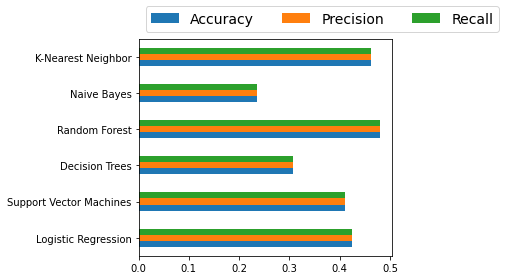

In [58]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()),
    bbox_to_anchor=(0, 1),
    loc='lower left',
    prop={'size': 14}
)
plt.tight_layout()

4

C:\Users\user\anaconda3\envs\keras-main\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


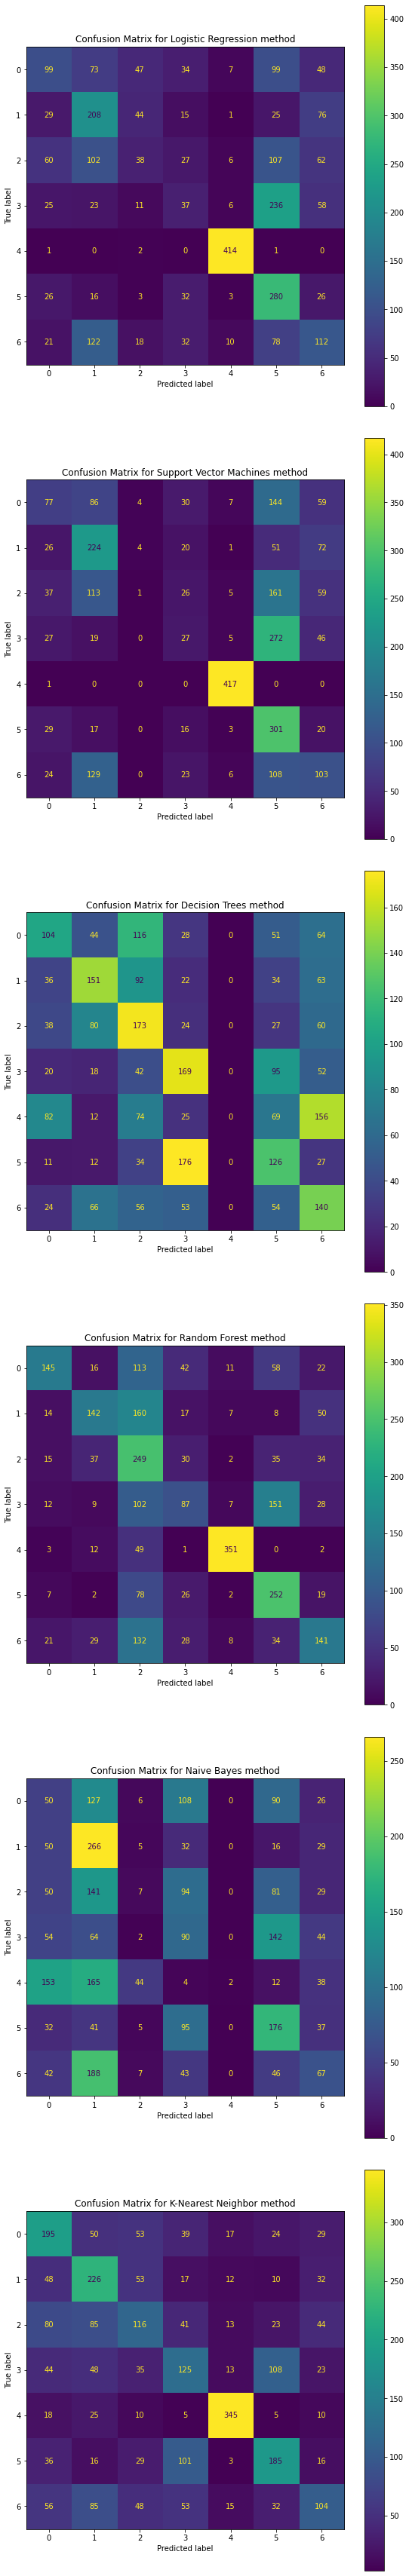

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Number of models
n_models = len(models)

# Create subplots with a single column
fig, axs = plt.subplots(n_models, 1, figsize=(8, 8 * n_models), sharey=False)

# If there's only one model, axs won't be an array
if n_models == 1:
    axs = [axs]

for idx, (key, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=feature_df['label'].unique())
    disp.plot(ax=axs[idx])
    disp.ax_.set_title(f'Confusion Matrix for {key} method')

plt.tight_layout()
plt.show()

# Using NN methods

In [223]:

import tensorflow as tf
import keras
import time
from keras.models import Sequential

from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Conv2D, MaxPool2D, InputLayer, BatchNormalization, \
    Input, Flatten, Activation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


In [238]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

n_features = X_train.shape[1]
n_classes = 7 

number_epoch = 20
batch_length = 16

inner_activation_fun = 'relu'
outer_activation_fun = 'softmax'
optimizer_loss_fun = 'categorical_crossentropy'
optimizer_algorithm = 'adam'
opt = keras.optimizers.Adam(learning_rate=0.001)


In [245]:

number_inner_layers = 5
number_inner_neurons = 2048
show_inter_results = 0

model = Sequential()
for i in range(number_inner_layers):
    number_inner_neurons=number_inner_neurons/2
    model.add(Dense(int(number_inner_neurons), input_dim=inp_shape[0], activation=inner_activation_fun))
    model.add(Dropout(0.3))
model.add(Dense(n_classes, activation=outer_activation_fun))



In [246]:

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 1024)              22528     
_________________________________________________________________
dropout_57 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_58 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)             

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Train on 11200 samples, validate on 2800 samples
Epoch 1/20
11200/11200 [==============================] - 9s 837us/step - loss: 1.5590 - accuracy: 0.3394 - val_loss: 1.3152 - val_accuracy: 0.4346
Epoch 2/20
11200/11200 [==============================] - 9s 770us/step - loss: 1.3271 - accuracy: 0.4281 - val_loss: 1.1323 - val_accuracy: 0.5193
Epoch 3/20
11200/11200 [==============================] - 9s 772us/step - loss: 1.2074 - accuracy: 0.4839 - val_loss: 1.1067 - val_accuracy: 0.5161
Epoch 4/20
11200/11200 [==============================] - 9s 786us/step - loss: 1.1490 - accuracy: 0.5055 - val_loss: 1.1033 - val_accuracy: 0.5157
Epoch 5/20
11200/11200 [==============================] - 9s 771us/step - loss: 1.1134 - accuracy: 0.5332 - val_loss: 1.1791 - val_accuracy: 0.5025
Epoch 6/20
11200/11200 [==============================] - 9s 768us/step - loss: 1.0831 - accuracy: 0.5441 - val_loss: 1.0584 

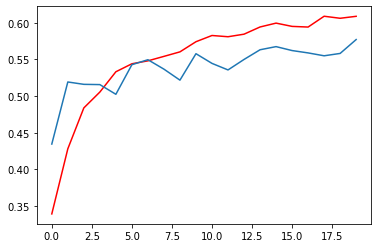

              precision    recall  f1-score   support

           0       0.81      0.50      0.62       407
           1       0.40      0.69      0.51       398
           2       0.59      0.44      0.50       402
           3       0.41      0.30      0.34       396
           4       0.88      0.99      0.93       418
           5       0.56      0.78      0.65       386
           6       0.48      0.33      0.39       393

    accuracy                           0.58      2800
   macro avg       0.59      0.57      0.56      2800
weighted avg       0.59      0.58      0.57      2800


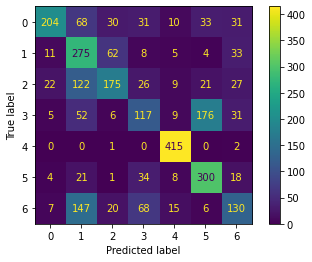

In [247]:

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)
start_tme = time.time()

history = model.fit(X_train, y_train, epochs=number_epoch, batch_size=batch_length, validation_data=(X_test, y_test))
end_time = time.time()
print(history.history)
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss : ", score[0])
print("Test Accuracy : ", score[1])
print("Training Time : ", end_time - start_tme)
y_pred = model.predict(X_test)
ytest = np.argmax(y_test, axis=1)
pred = np.argmax(y_pred, axis=1)
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'])
plt.show()
print(classification_report(ytest, pred))
cm = confusion_matrix(ytest, pred)
plot = ConfusionMatrixDisplay(cm)
plot.plot()
plt.show()